In [3]:
import tensorflow as tf
import numpy as np
import DifferentiableHOS as DHOS
import flowpm
import flowpm.tfpower as tfpower
import flowpm.scipy.interpolate as interpolate
import flowpm.raytracing as raytracing
import pickle
from flowpm.tfpower import linear_matter_power
import astropy.units as u
import tensorflow_addons as tfa
import flowpm.constants as constants
from itertools import cycle
import jax
import jax_cosmo as jc

In [2]:
n_lens = 22       # Number of lensplanes in the lightcone
box_size=100.     # Transverse comoving size of the simulation volume
nc = 64       # Number of transverse voxels in the simulation volume
field_size = 5.   # Size of the lensing field in degrees
field_npix =512 #1024  # Number of pixels in the lensing field
batch_size = 1    # Number of simulations to run in parallel
Omega_c=0.2589
sigma8=0.8159


In [42]:
@tf.function
def compute_kappa(Omega_c,sigma8):
    """ Computes a convergence map using ray-tracing through an N-body for a given
    set of cosmological parameters
    """
    # Instantiates a cosmology with desired parameters
    cosmology = flowpm.cosmology.Planck15(Omega_c=Omega_c,sigma8=sigma8)

    # Schedule the center of the lensplanes we want for ray tracing
    r = tf.linspace(0., box_size*n_lens, n_lens+1)
    r_center = 0.5*(r[1:] + r[:-1])

    # Retrieve the scale factor corresponding to these distances
    a = flowpm.tfbackground.a_of_chi(cosmology, r)
    a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)
    
    # We run 4 steps from initial scale factor to start of raytracing
    init_stages = tf.linspace(0.1, a[-1], 4)
    # Then one step per lens plane
    stages = tf.concat([init_stages, a_center[::-1]], axis=0)
    
    
    k = tf.constant(np.logspace(-4, 1, 256), dtype=tf.float32)
    pk = linear_matter_power(cosmology, k)
    pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)

    initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         pk_fun,         
                                         batch_size=batch_size)
    initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)
    
    # Run the Nbody
    states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True) 
    
    # Extract the lensplanes
    lensplanes = []
    matrix=flowpm.raytracing.rotation_matrices()
    for i,j in zip(range(len(a_center)),cycle(range(6))):
        plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2, #r_center[i]/box_size*nc,
                                            width=nc,
                                            plane_resolution=256,
                                            rotation=matrix[j],
                                            shift=flowpm.raytracing.random_2d_shift(),
                                            )
        plane = tf.expand_dims(plane, axis=-1)
        lensplanes.append((r_center[i], states[::-1][i][0], plane[...,0]))
    xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

    coords = np.stack([xgrid, ygrid], axis=0)*u.deg
    c = coords.reshape([2, -1]).T.to(u.rad)
    # Create array of source redshifts
    z_source = tf.linspace(0.5, 1, 4)
    m = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes, 
                    dx=box_size/256, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)
   
    m=tf.reshape(m,[batch_size, field_npix, field_npix, -1])
    
    return m,  lensplanes, r_center, a_center


In [44]:
m,  lensplanes, r_center, a_center=compute_kappa(Omega_c,sigma8)

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [4]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return tf.math.reduce_mean(tf.math.reduce_mean(tf.reshape(a,sh),axis=-1),axis=1)

In [77]:
def rebin(a, shape):
    sh = shape,a.shape[0]//shape
    return tf.math.reduce_mean(tf.reshape(a,sh),axis=-1)

In [78]:
@tf.function
def compute_jacobian(Omega_c, sigma8):
    """ Function that actually computes the Jacobian of a given statistics
    """
    params = tf.stack([Omega_c, sigma8])
    with tf.GradientTape() as tape:
        tape.watch(params)
        m, lensplanes, r_center, a_center = compute_kappa(params[0], params[1])
        ell, power_spectrum= DHOS.statistics.power_spectrum(m[0,:,:,-1],field_size,
                                                         field_npix)
        
        ell=rebin(ell,32)
        power_spectrum=rebin(power_spectrum,32)
        #power_spectrum=interpolate.interp_tf(tf.reshape(ell, [-1]), ell0,power_spectrum0)
        
        
#         k1 =tf.where(ell < 2000 ,False, True)
#         ell=tf.boolean_mask(ell, tf.math.logical_not(k1))
#         power_spectrum =tf.boolean_mask(power_spectrum, tf.math.logical_not(k1))
        
    return m,lensplanes, r_center, a_center, tape.jacobian(power_spectrum, params,
                             experimental_use_pfor=False), ell, power_spectrum


In [ ]:
 m,lensplanes, r_center, a_center,jac,ell,ps=compute_jacobian(Omega_c, sigma8)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [8]:
cosmo=jc.Planck15()
nz =jc.redshift.delta_nz(1.)
probes = [jc.probes.WeakLensing([nz])] 
cls = jc.angular_cl.angular_cl(cosmo, ell.numpy()[0], probes)
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell.numpy()[0], probes,f_sky=25/41252, sparse=True);

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [9]:
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ell.numpy()[0], probes)
  return m.flatten()
jac_mean = jax.jit(jax.jacfwd(mean_fn))
params = np.array([cosmo.Omega_c, cosmo.sigma8]) 
dmu = jac_mean(params)

In [10]:
F = jc.sparse.dot(dmu.T, jc.sparse.inv(cov), dmu)
F1= jc.sparse.dot(jac.numpy().T, jc.sparse.inv(cov), jac.numpy())

Populating the interactive namespace from numpy and matplotlib


/Users/dl264294/.conda/envs/env_nbody/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cov']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


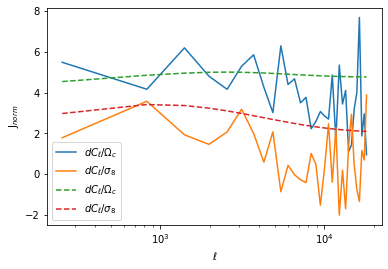

In [11]:
%pylab inline
semilogx(ell[0],jac[:,0]/ps,label='$dC_\ell/\Omega_c$')
semilogx(ell[0],jac[:,1]/ps,label='$dC_\ell/\sigma_8$')
semilogx(ell[0],dmu[:,0]/cls[0],'--',label='$dC_\ell/\Omega_c$')
semilogx(ell[0],dmu[:,1]/cls[0],'--',label='$dC_\ell/\sigma_8$')
ylabel('J$_{norm}$')
xlabel('$\ell$')
#xlim(0,3000)
#savefig('momcomp6.png',dpi=80)
legend()

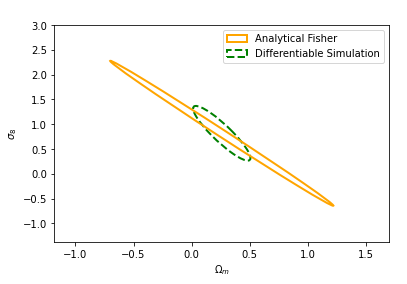

In [14]:
from DifferentiableHOS.Plot import plot_contours
ax = plt.axes()
#ax.set_facecolor('black')
ax2=plot_contours(F1, params, fill=False,label='Differentiable Simulation', color='green', lw=2, linestyle='dashed');
ax1=plot_contours(F, params, fill=False,label='Analytical Fisher',color='orange', lw=2,);
#ax.tick_params(colors='white', which='both')
xlabel('$\Omega_m$')#,color='white')
ylabel('$\sigma_8$')#,color='white');
title('Forecasted constraints on $\Omega_m$ and $\sigma_8$ from Power Spectrum ',color='white')
plt.legend([ax1,ax2],['Analytical Fisher','Differentiable Simulation'])
